### Data cleaning and preprocessing
First we import all necessary libraries for data processing, machine learning, and visualization, including pandas, numpy, scikit-learn, TensorFlow, and seaborn.

Then we loadd and prepared the shot data for Stephen Curry by retrieving multiple seasons, selecting relevant columns, engineering new features (such as time remaining and home/away status), and cleaning the dataset for further analysis.

In [2]:
# import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd
from nba_api.stats.endpoints import shotchartdetail
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# set it so we can see all columns in the dataframe (for clarity)
pd.set_option('display.max_columns', None)  

# establish the seasons we want to analyze
seasons = [
    '2016-17', '2017-18', '2018-19',
    '2019-20', '2020-21', '2021-22', '2022-23', '2023-24'
]

# function to find player data
def find_player(player_id):
    # get data for each season
    for season in seasons:
        shots = shotchartdetail.ShotChartDetail(
            team_id=0,
            player_id=player_id,  
            season_type_all_star='Regular Season',
            context_measure_simple='FGA',
            season_nullable=season
        ).get_data_frames()[0]
        shots['SEASON'] = season
        if 'shots_df' not in locals():
            shots_df = shots
        else:
            # add new shots to existing dataframe of shots
            shots_df = pd.concat([shots_df, shots], ignore_index=True)
    return shots_df

# make Curry dataframe
curry = find_player(201939)

# choose only relevant columns
df = curry[['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'LOC_X','LOC_Y', 'SHOT_MADE_FLAG', 'HTM', 'VTM']].copy()
df['Time_remaining'] = df['MINUTES_REMAINING'] * 60 + df['SECONDS_REMAINING']
df['Opponent'] = np.where(df['HTM']  == 'GSW', df['VTM'], df['HTM'])
df['Home'] = np.where(df['HTM'] == 'GSW', 1, 0)
df = df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM',"Opponent"])
df


,PERIOD,ACTION_TYPE,LOC_X,LOC_Y,SHOT_MADE_FLAG,Time_remaining,Home
0,1,Jump Shot,130,257,0,542,1
1,1,Step Back Jump shot,189,174,1,486,1
2,1,Jump Shot,159,229,0,143,1
3,1,Jump Shot,163,141,0,121,1
4,2,Jump Shot,-9,267,1,407,1
...,...,...,...,...,...,...,...
8890,4,Step Back Jump shot,129,243,1,19,0
8891,4,Pullup Jump shot,-4,290,0,0,0
8892,5,Jump Shot,1,294,1,237,0
8893,5,Driving Floating Jump Shot,70,142,1,147,0


## Feature Engineering & Selection to improve accuracy
We begin by constructing a new DataFrame containing key shot attributes, then engineer additional features such as the total time remaining in the period, whether the shot was taken at home, and the angle of the shot relative to the basket.

 The features are divided into numeric and categorical types. For numeric features, we use the ANOVA F-test to assess their relationship with the target variable (shot made or missed), while for categorical features, we use mutual information. 

The most informative features are selected based on these scores, and the selected features are combined into a new dataset for modeling. 

Finally, we visualize the top feature scores with a bar plot, providing insight into which variables are most influential in predicting shot outcomes.

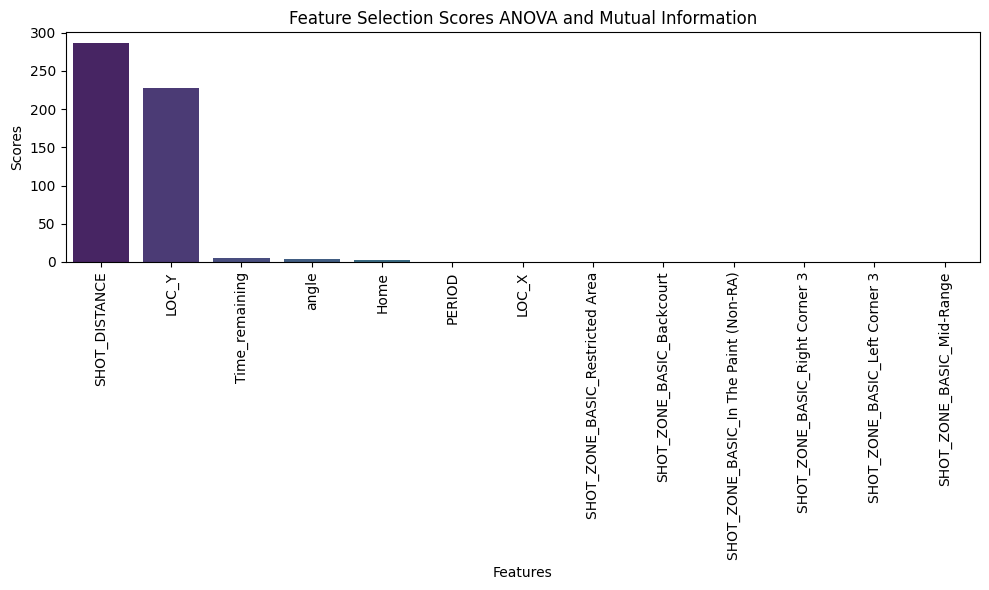

Selected Features:
['PERIOD', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Time_remaining', 'Home', 'angle', 'SHOT_ZONE_BASIC_Backcourt', 'SHOT_ZONE_BASIC_In The Paint (Non-RA)', 'SHOT_ZONE_BASIC_Left Corner 3', 'SHOT_ZONE_BASIC_Mid-Range', 'SHOT_ZONE_BASIC_Restricted Area', 'SHOT_ZONE_BASIC_Right Corner 3']


In [4]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
# makke a copy of the curry dataframe
curry_df = curry[['PERIOD', 'MINUTES_REMAINING', #'SHOT_ZONE_AREA',
       'SECONDS_REMAINING', 'SHOT_ZONE_BASIC', 'SHOT_DISTANCE',
       'LOC_X', 'LOC_Y', 'HTM', 'VTM', 'SHOT_MADE_FLAG']].copy()

# encode time and location features
curry_df['Time_remaining'] = curry_df['MINUTES_REMAINING'] * 60 + curry_df['SECONDS_REMAINING']
curry_df['Home'] = np.where(curry_df['HTM'] == 'GSW', 1, 0)
curry_df['angle'] = np.arctan2(curry_df['LOC_Y'], curry_df['LOC_X']) * (180 / np.pi)
curry_df = curry_df.drop(columns=['MINUTES_REMAINING', 'SECONDS_REMAINING', 'HTM', 'VTM'])

# separate features and target variable
X = curry_df.drop(columns=['SHOT_MADE_FLAG'])
y = curry_df['SHOT_MADE_FLAG']

numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

selector_num = SelectKBest(score_func=f_classif, k='all')
selector_num.fit(X[numeric_features], y)
selected_num_features = numeric_features[selector_num.get_support()]
num_scores = selector_num.scores_[selector_num.get_support()]

X_cat_encoded = pd.get_dummies(X[categorical_features], drop_first=True)
selector_cat = SelectKBest(score_func=mutual_info_classif, k='all')
selector_cat.fit(X_cat_encoded, y)
selected_cat_features = X_cat_encoded.columns[selector_cat.get_support()]
cat_scores = selector_cat.scores_[selector_cat.get_support()]

X_selected = pd.concat([X[selected_num_features].reset_index(drop=True), 
                        X_cat_encoded[selected_cat_features].reset_index(drop=True)], axis=1)

scores = pd.DataFrame({
    'Feature': list(selected_num_features) + list(selected_cat_features),
    'Score': list(num_scores) + list(cat_scores)
}).sort_values(by='Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Score', data=scores.head(20), palette='viridis', hue='Feature', legend=False)
plt.title('Feature Selection Scores ANOVA and Mutual Information')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Scores')
plt.tight_layout()
plt.show()

print("Selected Features:")
print(X_selected.columns.tolist())

### NN After Feature Selection

In this cell, we build and evaluate a neural network model to predict the outcome of Stephen Curry's shots using the features selected in the previous step. The process begins by converting the selected features to a suitable numeric format and splitting the data into training and testing sets. 

To address class imbalance in the target variable, class weights are computed and incorporated into the model training. The features are standardized to improve neural network performance. A Keras-based neural network is defined, with its architecture (number of layers, units, and dropout rate) and training parameters (batch size, epochs) set up for hyperparameter tuning using randomized search. 

The best model is selected based on cross-validation accuracy. Finally, the model's performance is evaluated on the test set, with results presented as a classification report and a confusion matrix heatmap, providing insight into the model's predictive accuracy and error distribution.

['PERIOD', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Time_remaining', 'Home', 'angle', 'SHOT_ZONE_BASIC_Backcourt', 'SHOT_ZONE_BASIC_In The Paint (Non-RA)', 'SHOT_ZONE_BASIC_Left Corner 3', 'SHOT_ZONE_BASIC_Mid-Range', 'SHOT_ZONE_BASIC_Restricted Area', 'SHOT_ZONE_BASIC_Right Corner 3']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__hidden_layers': [128, 64], 'model__dropout_rate': 0.3, 'epochs': 30, 'batch_size': 64}
Best Accuracy Score: 0.5763069139966274
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/stepBest Parameters: {'model__hidden_layers': [128, 64], 'model__dropout_rate': 0.3, 'epochs': 30, 'batch_size': 64}
Best Accuracy Score: 0.5763069139966274
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       956
           1       0.54      0.45      0.49       823

    accuracy                           0.56      1779
   macro avg

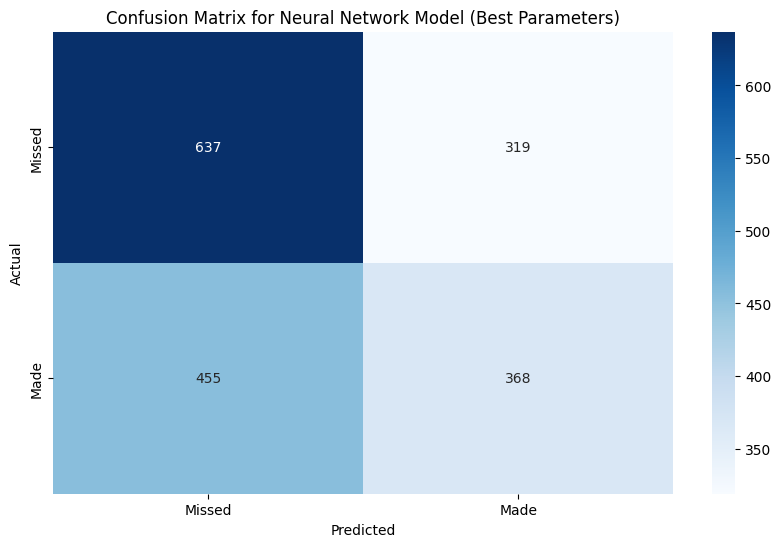

In [5]:
# Use the selected features from feature selection for the neural network
X = X_selected.astype('float32')
print(X.columns.tolist())

# Set the target variable to match the selected features
y = df['SHOT_MADE_FLAG']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the class distribution of the target variable (helps with class balancing)
y.value_counts(normalize=True)

# Compute class weights to address class imbalance in the target variable
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(enumerate(weights))

# Standardize features for neural network training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a function to build the Keras model for use in parameter search
def build_model(hidden_layers=[64, 32], dropout_rate=0.2):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_scaled.shape[1],)))
    model.add(keras.layers.Dense(hidden_layers[0], activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    if len(hidden_layers) > 1:
        for units in hidden_layers[1:]:
            model.add(keras.layers.Dense(units, activation='relu'))
            model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model for scikit-learn compatibility
model = KerasClassifier(model=build_model, verbose=0, class_weight=weights_dict)

# Define the parameter grid for tuning
param_grid = {
    'model__hidden_layers': [[64], [32,16], [64, 32], [128, 64]],
    'model__dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30, 40]
}

# Perform randomized search for best parameters
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, verbose=1, random_state=42)
random_search.fit(X_train_scaled, y_train)

print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Accuracy Score: {random_search.best_score_}')

# Evaluate the best model on the test set
y_pred_probs = random_search.best_estimator_.model_.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Neural Network Model (Best Parameters)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Saving the model
We then save the model so it can be accessed by the next part of our project (Deep Q Learning that will use probability as an input)

In [6]:
# Save the best Keras model for inference (returns probabilities)
best_keras_model = random_search.best_estimator_.model_
best_keras_model.save("CURRY_NN.keras")
print("Keras model saved as CURRY_NN.keras")

# To load the model later for inference:
# model = keras.models.load_model('CURRY_NN.keras')

Keras model saved as CURRY_NN.keras


## Other Models
We tested multiple other models to compare performance to NN.

## Random Forests

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Accuracy Score: 0.5671725688589095
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       956
           1       0.48      0.60      0.53       823

    accuracy                           0.52      1779
   macro avg       0.52      0.52      0.52      1779
weighted avg       0.53      0.52      0.51      1779

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest Accuracy Score: 0.5671725688589095
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       956
           1       0.48      0.60      0.53       823

    accuracy                           0.52      1779
   macro avg       0.52      0.52      0.52      1779
weighted avg       0.53      0.52      0.51

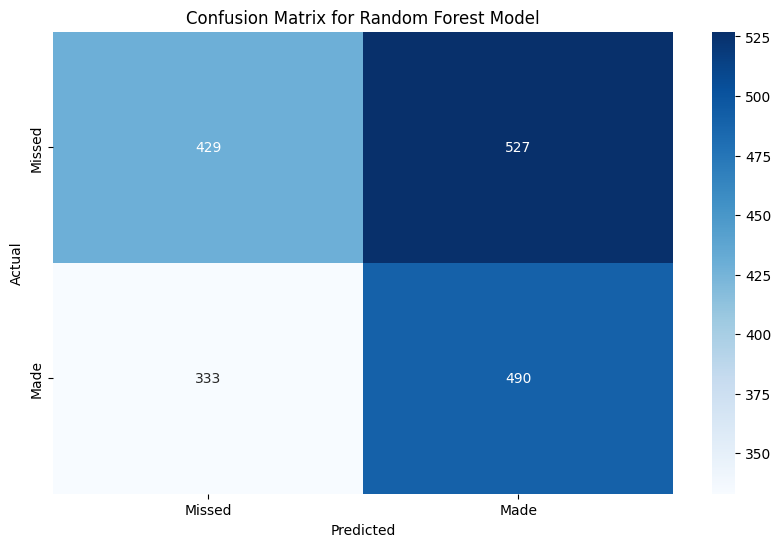

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {'n_estimators': [50, 100, 200], 
              'max_depth': [None, 10, 20, 30], 
              'min_samples_split': [2, 5, 10]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best Random Forest Parameters: {grid_search.best_params_}')
print(f'Best Random Forest Accuracy Score: {grid_search.best_score_}')
rf_best = grid_search.best_estimator_
y_pred = (rf_best.predict(X_test > 0.485)).astype(int)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Random Forest Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
rf_best = grid_search.best_estimator_
y_pred = (rf_best.predict(X_test > 0.485)).astype(int)


## XGboost

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.56      0.57       956
           1       0.51      0.55      0.53       823

    accuracy                           0.55      1779
   macro avg       0.55      0.55      0.55      1779
weighted avg       0.55      0.55      0.55      1779



/Users/williamnyman/Documents/GitHub/NBA-Actions/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [22:31:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


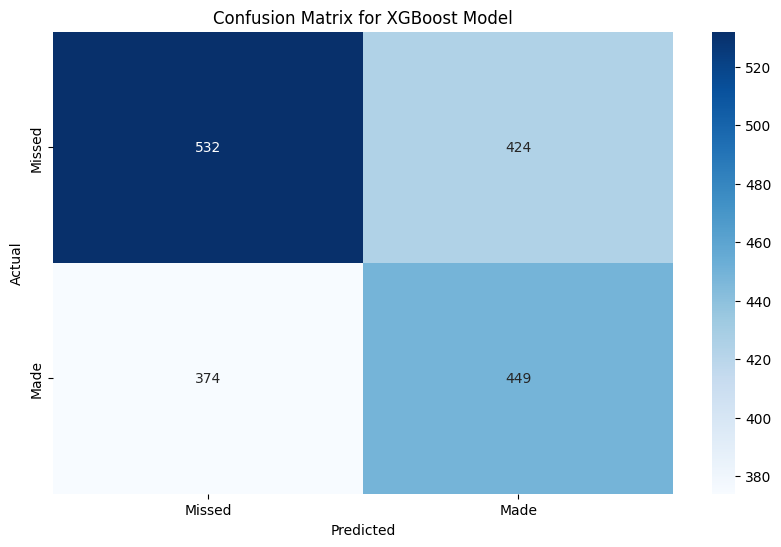

In [8]:
from xgboost import XGBClassifier

scale = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, xgb_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for XGBoost Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       956
           1       0.54      0.39      0.46       823

    accuracy                           0.56      1779
   macro avg       0.56      0.55      0.55      1779
weighted avg       0.56      0.56      0.55      1779



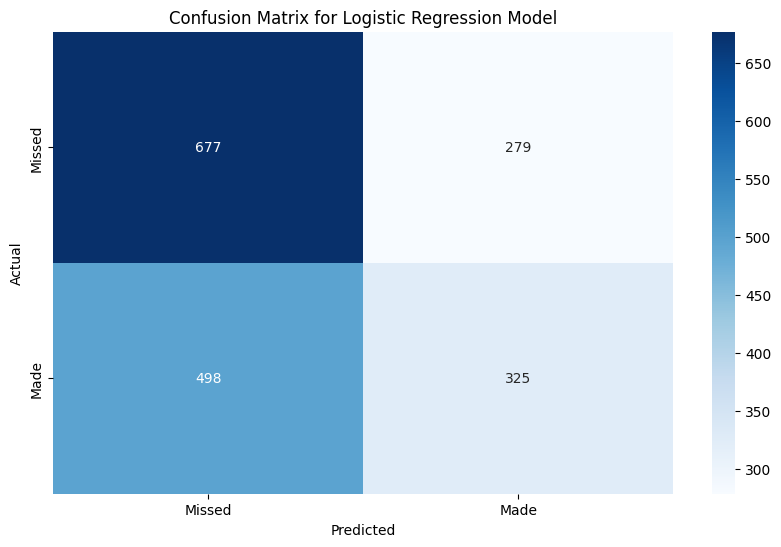

In [9]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
lg.fit(X_train, y_train)
lg_predictions = lg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lg_predictions))

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, lg_predictions), annot=True, fmt='d', cmap='Blues', xticklabels=['Missed', 'Made'], yticklabels=['Missed', 'Made'])
plt.title('Confusion Matrix for Logistic Regression Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()